# Section 1

Generating our data: a small dataset with in-distribution (IND) datapoints and a clearly separated out-of-distribution (OOD) cluster that we will use to test our models performance on unseen data. 

In [1]:
# 1. imports and set-up

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split 

plt.rcParams['figure.figsize'] = (6.2, 5.2)
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

rng = np.random.RandomState(42)


# 2. generate our IND data - two interlocking half circles (moons)
X_all, y_all = make_moons(n_samples=600, noise=0.2, random_state=rng)

X_train, X_ind_test, y_train, y_ind_test = train_test_split(
    X_all, y_all, test_size=0.3, random_state=rng, stratify=y_all
)


# 3. generate OOD data - separate gaussian cluster
X_ood = rng.normal(loc=[3.4, 3.0], scale=[0.35, 0.35], size=(120, 2))


# 4. print shape summary
print("Shapes:",
        "Train:", X_train.shape,
        "IND test:", X_ind_test.shape,
        "OOD test:", X_ood.shape
)


Shapes: Train: (420, 2) IND test: (180, 2) OOD test: (120, 2)


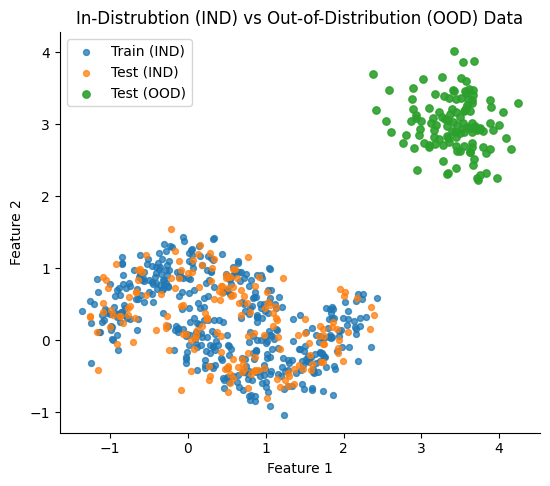

In [2]:
X_train_plot = X_train
X_test_plot = X_ind_test

fig, ax = plt.subplots()

ax.scatter(X_train_plot[:, 0], X_train_plot[:, 1], s=18, label='Train (IND)', alpha=0.75)
ax.scatter(X_test_plot[:, 0], X_test_plot[:, 1], s=18, label='Test (IND)', alpha=0.75)
ax.scatter(X_ood[:, 0], X_ood[:, 1], s=28, label='Test (OOD)', alpha=0.9)

ax.set_title("In-Distrubtion (IND) vs Out-of-Distribution (OOD) Data")
ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")
ax.legend()
plt.show()

In [5]:
import os, joblib 

os.makedirs("artifacts", exist_ok=True)

# save arrays
np.save("artifacts/X_train.npy", X_train)
np.save("artifacts/y_train.npy", y_train)
np.save("artifacts/X_ind_test.npy", X_ind_test)
np.save("artifacts/y_ind_test.npy", y_ind_test)
np.save("artifacts/X_ood.npy", X_ood)

# save as a csv for easy viewing and also for streamlit demos 
pd.DataFrame(np.c_[X_train, y_train], columns=["x1", "x2", "y"]).to_csv("artifacts/train_data.csv", index=False)
pd.DataFrame(np.c_[X_ind_test, y_ind_test], columns=["x1", "x2", "y"]).to_csv("artifacts/test_ind_data.csv", index=False)
pd.DataFrame(X_ood, columns=["x1", "x2"]).to_csv("artifacts/ood_data.csv", index=False)

print("Saved data to artifacts/ folder")

Saved data to artifacts/ folder


In [6]:
def describe(name, X):
    m = X.mean(axis=0)
    s = X.std(axis=0)
    print(f"{name:>10s} | mean: {m[0]:.3f}, {m[1]:.3f} | std: {s[0]:.3f}, {s[1]:.3f}")


describe("Train", X_train)
describe("IND Test", X_ind_test)
describe("OOD Test", X_ood)

     Train | mean: 0.506, 0.270 | std: 0.904, 0.545
  IND Test | mean: 0.504, 0.267 | std: 0.883, 0.526
  OOD Test | mean: 3.420, 3.005 | std: 0.358, 0.368


# Section 2

Build a baseline classifier (logistic regression) and see why its overconfident on OOD.

Logistic regression:
- computes a linear score (describes how likely it is for a datapoint to fit into a class)
- pass it through a **sigmoid** function - an S-shaped curve 
- the sigmoid "translates" our score into a probability
- if the score is very positive or very negative, the sigmoid satures near 1 or 0 -- i.e. high confidence

-> objective: notice that our model will have high confidence even on data thats far from the training distribution

**WARNING:** overconfidence on unfamiliar inputs 

In [8]:
from pathlib import Path

ART = Path("artifacts")
rng = np.random.RandomState(42)

def load_data():
    if (ART / "X_train.npy").exists():
        X_train = np.load(ART / "X_train.npy")
        y_train = np.load(ART / "y_train.npy")
        X_ind_test = np.load(ART / "X_ind_test.npy")
        y_ind_test = np.load(ART / "y_ind_test.npy")
        X_ood = np.load(ART / "X_ood.npy")
        print("Loaded data from artifacts/")
    else:
        raise FileNotFoundError("Data not found. Please run detection.ipynb to generate data.")
    return X_train, y_train, X_ind_test, y_ind_test, X_ood

X_train, y_train, X_ind_test, y_ind_test, X_ood = load_data()
print("Shapes:",
        "Train:", X_train.shape,
        "IND test:", X_ind_test.shape,
        "OOD test:", X_ood.shape
)

Loaded data from artifacts/
Shapes: Train: (420, 2) IND test: (180, 2) OOD test: (120, 2)


In [9]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

clf = make_pipeline(
    StandardScaler(), # puts our features on comparable scales
    LogisticRegression(random_state=rng) # logistic regression model
)

clf.fit(X_train, y_train)
print("Trained model.")

Trained model.


In [10]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

y_pred_ind = clf.predict(X_ind_test)
acc = accuracy_score(y_ind_test, y_pred_ind)
print(f"IND Test Accuracy: {acc:.3f}")
print(f"Classification Report:\n{classification_report(y_ind_test, y_pred_ind)}")
cm = confusion_matrix(y_ind_test, y_pred_ind)
print(f"Confusion Matrix:\n{cm}")

IND Test Accuracy: 0.872
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.89      0.87        90
           1       0.89      0.86      0.87        90

    accuracy                           0.87       180
   macro avg       0.87      0.87      0.87       180
weighted avg       0.87      0.87      0.87       180

Confusion Matrix:
[[80 10]
 [13 77]]


C:\Users\quinn\AppData\Local\Temp\ipykernel_22128\870393685.py:21: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(xx,yy, probs, levels=[0.5], colors='black', linestyles='--', linewidths=2, label='Decision Boundary')


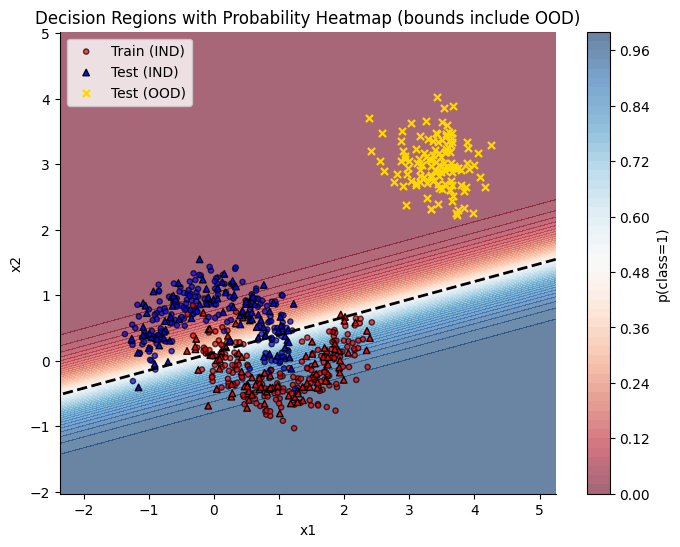

In [19]:
# construct bounds that include train and OOD data
X_for_bounds = np.vstack([X_train, X_ood])
pad = 1.0

x_min, x_max = X_for_bounds[:, 0].min() - pad, X_for_bounds[:, 0].max() + pad
y_min, y_max = X_for_bounds[:, 1].min() - pad, X_for_bounds[:, 1].max() + pad

# grid of points across this rectangle 
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500), np.linspace(y_min, y_max, 500))
grid = np.c_[xx.ravel(), yy.ravel()]

# predict probability of class 1 for each point in the grid
probs = clf.predict_proba(grid)[:, 1].reshape(xx.shape)

# plotting 
plt.figure(figsize=(8, 6))
contour = plt.contourf(xx, yy, probs, levels=50, cmap="RdBu", alpha=0.6)
cbar = plt.colorbar(contour)
cbar.set_label("p(class=1)")

plt.contour(xx,yy, probs, levels=[0.5], colors='black', linestyles='--', linewidths=2, label='Decision Boundary')

plt.scatter(X_train[:, 0], X_train[:, 1],
            c=y_train, cmap="bwr", s=14, edgecolor="k", alpha=0.70, label="Train (IND)")
plt.scatter(X_ind_test[:, 0], X_ind_test[:, 1],
            c=y_ind_test, cmap="bwr", s=22, marker="^", edgecolor="k", alpha=0.95, label="Test (IND)")
plt.scatter(X_ood[:, 0], X_ood[:, 1],
            c="gold", s=26, marker="x", linewidths=1.6, label="Test (OOD)")

plt.title("Decision Regions with Probability Heatmap (bounds include OOD)")
plt.xlabel("x1"); plt.ylabel("x2")
plt.legend(loc="upper left")
plt.show()

Median IND confidence: 0.917
Median OOD confidence: 1.000


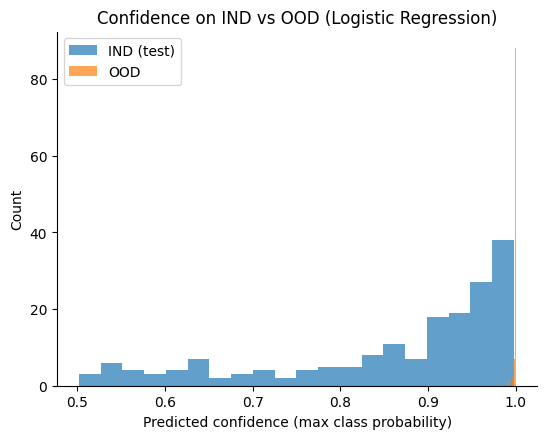

Fraction of OOD with confidence ≥ 0.95: 100.00%


In [20]:
# --- Compare predicted confidence on IND vs OOD ---

# For each point, the model predicts p(class=1) and p(class=0) = 1 - p1
proba_ind = clf.predict_proba(X_ind_test)  # shape: [N, 2]
proba_ood = clf.predict_proba(X_ood)       # shape: [M, 2]

# Take the chosen class probability (max over classes) as the model's "confidence"
conf_ind = proba_ind.max(axis=1)
conf_ood = proba_ood.max(axis=1)

print(f"Median IND confidence: {np.median(conf_ind):.3f}")
print(f"Median OOD confidence: {np.median(conf_ood):.3f}")

# Visualize distributions
plt.figure(figsize=(6.2, 4.6))
plt.hist(conf_ind, bins=20, alpha=0.70, label="IND (test)")
plt.hist(conf_ood, bins=20, alpha=0.70, label="OOD")
plt.xlabel("Predicted confidence (max class probability)")
plt.ylabel("Count")
plt.title("Confidence on IND vs OOD (Logistic Regression)")
plt.legend()
plt.show()

# What fraction of OOD is assigned very high confidence?
high_thr = 0.95
print(f"Fraction of OOD with confidence ≥ {high_thr:.2f}: {(conf_ood >= high_thr).mean():.2%}")